In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import math
import torch.optim as optim
import time
import os
import copy
import numpy as np
import random
import pickle

def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(20)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

transform_train = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=4)
# import data_reader
# trainloader, testloader = data_reader.data_loader()

dataloaders_dict = {'train': trainloader, 'val':testloader}
print('data loading finished!')

cuda:1
Files already downloaded and verified
Files already downloaded and verified
data loading finished!


In [2]:
# print(trainset[0][0].shape)
# # print(dir(torchvision.datasets))
# voc_trainset = torchvision.datasets.VOCSegmentation('./data/voc_dataset', year='2012', image_set='train', download=True)

In [3]:
# print(voc_trainset[0][0])
# print(voc_trainset[0][1])

In [4]:
import torchvision.models as models
 
model_name = 'resnet50' # 'vgg16'   
num_classes = 10

if model_name.lower() == 'vgg16':
    model_ft = models.vgg16(pretrained=True)
elif model_name.lower() == 'alexnet':
    model_ft = models.alexnet(pretrained=True)
elif model_name.lower() == 'resnet50':
    model_ft = models.resnet50(pretrained=True)
else:
    raise ValueError

for param in model_ft.parameters():
    param.requires_grad = False

if model_name.lower() == 'vgg16' or model_name == 'alexnet':
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
elif model_name.lower() == 'resnet50':
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 10)
else:
    raise ValueError
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [5]:
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()
optimizer_ft = optim.SGD(params_to_update, lr=0.003, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_of_coarse=3, num_epochs=10, is_resnet=False):
    since = time.time()

    train_val_history = []
    

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        train_val = {}
        
        if epoch >= num_of_coarse and not is_resnet:
            for param in model_ft.classifier.parameters():
                param.requires_grad = True
            
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.long()
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            train_val[phase] = (epoch_loss, epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#             if phase == 'val':
#                 val_acc_history.append(epoch_acc)
        
        train_val_history.append(train_val)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_val_history
    

In [7]:
model_ft, history = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, 6, 15, True)

Epoch 1/15
----------
train Loss: 0.8883 Acc: 0.7272
val Loss: 0.6513 Acc: 0.7878

Epoch 2/15
----------
train Loss: 0.6259 Acc: 0.7905
val Loss: 0.5944 Acc: 0.8038

Epoch 3/15
----------
train Loss: 0.5828 Acc: 0.8020
val Loss: 0.5730 Acc: 0.8053

Epoch 4/15
----------
train Loss: 0.5627 Acc: 0.8080
val Loss: 0.5532 Acc: 0.8083

Epoch 5/15
----------
train Loss: 0.5466 Acc: 0.8133
val Loss: 0.5503 Acc: 0.8106

Epoch 6/15
----------
train Loss: 0.5355 Acc: 0.8151
val Loss: 0.5414 Acc: 0.8123

Epoch 7/15
----------
train Loss: 0.5270 Acc: 0.8178
val Loss: 0.5334 Acc: 0.8188

Epoch 8/15
----------
train Loss: 0.5195 Acc: 0.8195
val Loss: 0.5343 Acc: 0.8145

Epoch 9/15
----------
train Loss: 0.5108 Acc: 0.8228
val Loss: 0.5258 Acc: 0.8207

Epoch 10/15
----------
train Loss: 0.5081 Acc: 0.8228
val Loss: 0.5316 Acc: 0.8172

Epoch 11/15
----------
train Loss: 0.5029 Acc: 0.8266
val Loss: 0.5287 Acc: 0.8184

Epoch 12/15
----------
train Loss: 0.4958 Acc: 0.8278
val Loss: 0.5156 Acc: 0.8215

E

In [8]:
torch.save(model_ft.state_dict(), 'data/models/{}_v1.model'.format(model_name))
with open('data/trainHistory/{}_history_v1.pkl'.format(model_name), 'wb') as f:
    pickle.dump(history, f)

In [10]:
train_X, train_y, test_X, test_y = data_reader.get_data_array('cifar-10', 'data/cifar-10-batches-py')

In [11]:
img = train_X[120] 
print(img.shape)

(32, 32, 3)


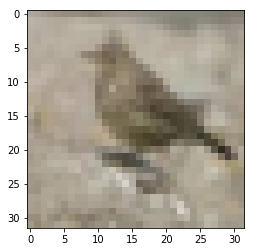

In [12]:
import matplotlib.pyplot as plt
img = train_X[120]
% matplotlib inline
plt.figure('cam')
plt.imshow(img / 255.)
plt.show()